## 몬테카를로 예측

- MDP 문제를 해결하기 위해서는  가치 이터레이션과 정책 이터레이션 방법 모두 모델의 동작 특성을 알고 있어야 함. 
- 모델의 동작 특성을 모를때, 몬테카를로 방법을 사용
- 몬테카를로 방법은 상태, 행동 및 보상으로 구성된 샘플만 있으면 가능
- 몬테카를로 예측은 총누적보상의 기대값 대신 총누적 보상의 평균을 사용하여 가치 함수를 근사

#### 몬테카를로 예측의 동작 단계
1. 가치함수를 임의의 값으로 초기화
2. 총누적보상 값을 저장하기 위해, return이라는 리스트를 초기화
3. 에피소드의 각 상태마다 총누적보상을 계산
4. 3단계에서 계산된 총누적보상값을 2단계의 return 리스트에 추가
5. 마지막으로 총누적보상 값들의 평균을 가치함수로 사용

#### 몬테카를로 예측 알고리즘 2가지 유형
- 일회 방문 몬테카를로
   - 한 에피소드에서 특정 상태를 처음 방문했을때만 총누적보상의 평균값을 계산, 중복계산하지 않음.
- 매회 방문 몬테카를로
   - 에이전트가 특정 상태를 방문할때마다 총누적보상의 평균값을 얻음.



# 일회 방문 몬테카를로 방법으로 블랙잭 게임

필요한 라이브러리 import 

In [0]:
import gym
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
from functools import partial
%matplotlib inline
plt.style.use('ggplot')

OpenAI Gym으로  Blackjack 환경 만들기 

In [0]:
env = gym.make('Blackjack-v0')

현재 상태의 score가 20보다 크거나 같은지 확인하는 정책함수 sample_policy()함수 정의
- score가 20보다 크거나 같으면 0을 반환하여, 20보다 크거나 같으면 stand(0)를 하고 그렇지 않으면 hit(1)를 하겠다는 정책

In [0]:
def sample_policy(observation):
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

한번의 에피소드를 생성하는 함수 정의

In [0]:
def generate_episode(policy, env):
    
    # states, actions, and rewards 변수를 리스트 타입으로 정의
    states, actions, rewards = [], [], []
    
    # env.reset()함수를 사용하여 환경을 초기화
    observation = env.reset()
    
    # 최종 단계까지 에피소드가 끝날때가지 수행
    while True:
        
        # observation 변수를 states 리스트에 추가.
        states.append(observation)
        
        # sample_policy() 함수를 사용하여 행동을 선택하고 action 리스트에 추가
        action = sample_policy(observation)
        actions.append(action)
        
        # 환경의 각 단계별로 상태 state, 보상 reward 및 done 변수를 저장하고 보상을 rewards 리스트에 추가
        observation, reward, done, info = env.step(action)
        rewards.append(reward)
        
        # Break if the state is a terminal state
        if done:
             break
                
    return states, actions, rewards

일회 방문 몬테카를로 방법을 사용하여 각 상태의 가치를 얻는 함수를 정의

In [0]:
def first_visit_mc_prediction(policy, env, n_episodes):
    
    # value_table 변수를 딕셔너리 타입으로 초기화하여 각 상태의 값을 저장할 공간을 만듬.
    value_table = defaultdict(float)
    N = defaultdict(int)

    
    for _ in range(n_episodes):
        
        # 에피소드를 생성하고 states와 rewards변수를 저장.
        # 총 누적보상 returns 변수는 0으로 초기화.
        states, _, rewards = generate_episode(policy, env)
        returns = 0
        
        # 각 단계에서 보상을 변수 R에 저장하고 변수 S에 상태를 저장
        # 총누적보상 returns는 보상의 합계를 계산
        
        for t in range(len(states) - 1, -1, -1):
            R = rewards[t]
            S = states[t]
            
            returns += R
            
            # 에피소드에서 해당 상태 S를 처음 방문했는지를 확인하고
            # 처음 방문하면, 총누적보상 returns의 평균값을 구하고,
            # 이 값을 해당 가치 value_table[S]에 할당.
            if S not in states[:t]:
                N[S] += 1
                value_table[S] += (returns - value_table[S]) / N[S]
    
    return value_table

In [0]:
value = first_visit_mc_prediction(sample_policy, env, n_episodes=500000)

Let us see first few elements in the value table

In [0]:
for i in range(10):
  print(value.popitem())

((13, 8, True), -0.3239130434782607)
((12, 1, True), -0.4482758620689656)
((14, 9, True), -0.2613861386138614)
((14, 2, True), -0.26744186046511637)
((4, 8, False), -0.32017543859649106)
((19, 3, True), -0.46208530805687204)
((4, 7, False), -0.41048034934497807)
((13, 3, True), -0.2767676767676771)
((9, 3, False), -0.524632117722329)
((13, 6, True), -0.200902934537246)


 We define the function plot_blackjack for plotting the value function and we can see how our value function is attaining the convergence. 

In [0]:
def plot_blackjack(V, ax1, ax2):
    player_sum = np.arange(12, 21 + 1)
    dealer_show = np.arange(1, 10 + 1)
    usable_ace = np.array([False, True])
    state_values = np.zeros((len(player_sum), len(dealer_show), len(usable_ace)))

    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_show):
            for k, ace in enumerate(usable_ace):
                state_values[i, j, k] = V[player, dealer, ace]
    
    X, Y = np.meshgrid(player_sum, dealer_show)
 
    ax1.plot_wireframe(X, Y, state_values[:, :, 0])
    ax2.plot_wireframe(X, Y, state_values[:, :, 1])
 
    for ax in ax1, ax2:
        ax.set_zlim(-1, 1)
        ax.set_ylabel('player sum')
        ax.set_xlabel('dealer showing')
        ax.set_zlabel('state-value')
        

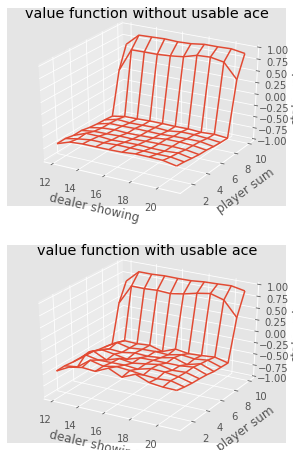

In [8]:
fig, axes = pyplot.subplots(nrows=2, figsize=(5, 8),
subplot_kw={'projection': '3d'})
axes[0].set_title('value function without usable ace')
axes[1].set_title('value function with usable ace')
plot_blackjack(value, axes[0], axes[1])